# Lab 17b: Fine-Tuning with Knowledge Distillation

This lab demonstrates how to improve a small model's (**Phi-4-mini**) domain-specific performance by "distilling" knowledge from a larger teacher model (**DeepSeek-V3.2**).

**Workflow:**
1. **Teacher Evaluation**: Measure DeepSeek's performance on real ISS reports.
2. **Generate Training Data**: Create 500+ training examples using:
   - Real NASA reports (filtered to only correct teacher predictions)
   - Synthetic ISS reports generated by DeepSeek
3. **Fine-Tune on Azure**: Train Phi-4-mini on Azure Container Apps (A100 GPU).
4. **Evaluate via API**: Test fine-tuned model on Azure Container Apps (A100 GPU).
5. **Local Demo**: Run the fine-tuned model locally on a single report.

**Models Used:**
1. **DeepSeek-V3.2** (Teacher - Cloud API)
2. **Phi-4-Mini** (Base - Cloud API via Azure ML)
3. **Phi-4-Mini + LoRA** (Fine-Tuned - Local)

In [ ]:
# Setup Dependencies
%pip install openai azure-ai-inference azure-identity pandas matplotlib transformers peft torch tqdm -q
print("Dependencies installed.")

In [1]:
import os
import re
import json
import torch
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load local helpers
from iss_utils import get_evaluation_dataset, fetch_report, create_classification_prompt, parse_classification_response, evaluate_classification
from azure_infra import provision_infrastructure, submit_finetune_job, monitor_job, download_model

# Suppress tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load environment
load_dotenv("../.env")
print("Environment loaded.")

Environment loaded.


## 1. Prepare Evaluation Dataset

We will compile a dataset of real days from the ISS mission history—some with documented incidents (Critical/Warning) and some with routine operations (Nominal).

In [10]:
# 1. Get List of Dates to Evaluate
eval_dataset = get_evaluation_dataset()
print(f"Dataset: {len(eval_dataset)} evaluation points")
print(f"- Incidents: {sum(1 for d in eval_dataset if d['is_incident'])}")
print(f"- Normal Days: {sum(1 for d in eval_dataset if not d['is_incident'])}")

# 2. Fetch NASA Reports for these days
print("\nFetching NASA reports...")
reports_data = {}
for item in tqdm(eval_dataset):
    date = item["date"]
    if date not in reports_data:
        res = fetch_report(date)
        if res["success"]:
            reports_data[date] = res

print(f"Successfully fetched {len(reports_data)} reports.")

Dataset: 35 evaluation points
- Incidents: 17
- Normal Days: 18

Fetching NASA reports...


100%|██████████| 35/35 [00:41<00:00,  1.19s/it]

Successfully fetched 35 reports.


## 2. Evaluate Teacher Model (DeepSeek-V3.2)

We use **DeepSeek-V3.2** (hosted on Azure APIM) as our "Teacher". It provides high-quality classifications that we use to:
1. Establish the target accuracy (~80%)
2. Generate training labels for knowledge distillation

> **Why DeepSeek?** As an open-source model, DeepSeek's outputs can be freely used for training derivative models—an important consideration when building knowledge distillation pipelines.

In [8]:
# Configure Teacher Model
APIM_URL = os.getenv("APIM_URL")
APIM_KEY = os.getenv("APIM_KEY")
TEACHER_MODEL = "DeepSeek-V3.2"

client = AzureOpenAI(
    azure_endpoint=APIM_URL.rstrip('/').replace('/openai', ''),
    api_key=APIM_KEY,
    api_version="2024-12-01-preview"
)

In [17]:
def query_teacher(report_text):
    prompts = create_classification_prompt(report_text)
    response = client.chat.completions.create(
        model=TEACHER_MODEL,
        messages=[{"role": "system", "content": prompts["system"]}, 
                  {"role": "user", "content": prompts["user"]}],
        temperature=0.1, max_tokens=500
    )
    return response.choices[0].message.content, prompts

# Run Evaluation
teacher_results = []
print("Evaluating Teacher (DeepSeek)...")

for item in tqdm(eval_dataset):
    if item["date"] not in reports_data: continue
    
    report = reports_data[item["date"]]
    raw_response, prompts = query_teacher(report["report_text"])
    
    # Parse & Grade
    prediction = parse_classification_response(raw_response)
    metrics = evaluate_classification(prediction, item)
    
    teacher_results.append({
        "date": item["date"],
        "metrics": metrics,
        "prediction": prediction,
        "raw_response": raw_response,
        "prompts": prompts  # Save for training data generation
    })

accuracy = sum(1 for r in teacher_results if r["metrics"]["severity_exact_match"]) / len(teacher_results)
print(f"\n🎓 Teacher Accuracy: {accuracy:.1%}")

Evaluating Teacher (DeepSeek)...


100%|██████████| 35/35 [02:26<00:00,  4.19s/it]


🎓 Teacher Accuracy: 80.0%


## Evaluate Base model

Reference baseline from earlier local testing

In [21]:
BASE_MODEL_ID = "microsoft/Phi-4-mini-instruct"
base_acc = 0.457

print(f"Base Model: {BASE_MODEL_ID}")
print(f"Reference Baseline Accuracy: {base_acc:.1%}")
print("(Skipping local baseline - using reference value for comparison)")

Base Model: microsoft/Phi-4-mini-instruct
Reference Baseline Accuracy: 45.7%
(Skipping local baseline - using reference value for comparison)


## 3. Generate Training Data (~500 Examples)

We create a high-quality training dataset by:
1. **Filtering Real Data**: Only use reports where the teacher's prediction matched ground truth
2. **Generating Synthetic Data**: Use DeepSeek to create realistic ISS reports with known severities

This gives us enough diverse examples for effective fine-tuning.

In [3]:
# Load existing training data or generate new
TRAIN_FILE = "data/train.jsonl"

if os.path.exists(TRAIN_FILE):
    print(f"Loading existing training data from {TRAIN_FILE}...")
    all_training = []
    with open(TRAIN_FILE, "r") as f:
        for line in f:
            all_training.append(json.loads(line))
    print(f"Loaded {len(all_training)} examples")
    
    # Show severity distribution
    severities = []
    for ex in all_training:
        match = re.search(r'SEVERITY:\s*(\w+)', ex["assistant"], re.IGNORECASE)
        if match:
            severities.append(match.group(1).lower())
    print(f"Severity distribution: {Counter(severities)}")
else:
    print("No existing training data found. Generating...")
    
    # Reload iss_utils to pick up new functions
    import importlib
    import iss_utils
    importlib.reload(iss_utils)
    from iss_utils import get_synthetic_scenarios, create_synthetic_report_prompt, create_classification_prompt

    # --- Step 1: Filter Real Data (only correct predictions) ---
    real_training = []
    for res in teacher_results:
        if res["metrics"]["severity_exact_match"]:  # Only correct predictions
            example = {
                "system": res["prompts"]["system"],
                "user": res["prompts"]["user"],
                "assistant": res["raw_response"]
            }
            real_training.append(example)
            
    print(f"Real data (filtered): {len(real_training)} examples")

    # --- Step 2: Generate Synthetic Reports ---
    TARGET_TOTAL = 500
    synthetic_needed = TARGET_TOTAL - len(real_training)
    scenarios = get_synthetic_scenarios(synthetic_needed)

    print(f"Generating {len(scenarios)} synthetic reports...")
    synthetic_training = []

    for i, scenario in enumerate(tqdm(scenarios)):
        try:
            # Step 2a: Generate synthetic report
            gen_prompt = create_synthetic_report_prompt(scenario)
            gen_response = client.chat.completions.create(
                model=TEACHER_MODEL,
                messages=[
                    {"role": "system", "content": gen_prompt["system"]},
                    {"role": "user", "content": gen_prompt["user"]}
                ],
                temperature=0.8,  # More creativity for variety
                max_tokens=800
            )
            synthetic_report = gen_response.choices[0].message.content
            
            # Step 2b: Have teacher classify the synthetic report
            class_prompt = create_classification_prompt(synthetic_report)
            class_response = client.chat.completions.create(
                model=TEACHER_MODEL,
                messages=[
                    {"role": "system", "content": class_prompt["system"]},
                    {"role": "user", "content": class_prompt["user"]}
                ],
                temperature=0.1,
                max_tokens=500
            )
            classification = class_response.choices[0].message.content
            
            # Create training example
            example = {
                "system": class_prompt["system"],
                "user": class_prompt["user"],
                "assistant": classification
            }
            synthetic_training.append(example)
            
        except Exception as e:
            print(f"Error on scenario {i}: {e}")
            continue

    print(f"Synthetic data: {len(synthetic_training)} examples")

    # --- Step 3: Combine and Save ---
    all_training = real_training + synthetic_training
    print(f"\nTotal training examples: {len(all_training)}")

    # Severity distribution check
    severities = []
    for ex in all_training:
        match = re.search(r'SEVERITY:\s*(\w+)', ex["assistant"], re.IGNORECASE)
        if match:
            severities.append(match.group(1).lower())
    print(f"Severity distribution: {Counter(severities)}")

    # Save to JSONL
    os.makedirs("data", exist_ok=True)
    with open(TRAIN_FILE, "w") as f:
        for ex in all_training:
            f.write(json.dumps(ex) + "\n")

    print(f"\nSaved {len(all_training)} examples to {TRAIN_FILE}")

Loading existing training data from data/train.jsonl...
Loaded 500 examples
Severity distribution: Counter({'nominal': 247, 'caution': 116, 'warning': 69, 'advisory': 43, 'critical': 25})


## 4. Fine-Tune on Azure Container Apps (Serverless GPU)

Submit a fine-tuning job to Azure Container Apps with an **NVIDIA A100 GPU** using **Microsoft Olive**.

In [6]:
# Configuration
RESOURCE_GROUP = "iss-finetuning-rg"
LOCATION = "swedencentral"  # A100 availability
STORAGE_ACCOUNT = "issft" + os.environ.get("USER", "dev")[:8].replace("-", "")
ACA_ENV = "iss-aca-env"
CONTAINER_NAME = "training-data"
JOB_NAME = "iss-ft-job"

In [ ]:
print(f"Training Config: {RESOURCE_GROUP} | {LOCATION}")

# 1. Provision Infrastructure
env_id = provision_infrastructure(RESOURCE_GROUP, LOCATION, STORAGE_ACCOUNT, CONTAINER_NAME, ACA_ENV, "data/train.jsonl")

# 2. Submit Job
submit_finetune_job(
    JOB_NAME, RESOURCE_GROUP, env_id, STORAGE_ACCOUNT, CONTAINER_NAME, 
    base_model=BASE_MODEL_ID, location=LOCATION
)

# 3. Monitor (this takes ~15-20 mins)
success = monitor_job(JOB_NAME, RESOURCE_GROUP)


In [8]:
if success:
    print("✅ Fine-tuning completed successfully!")
    print("Adapter saved to blob storage. Will evaluate on ACA next.")
else:
    print("❌ Training failed. Check Azure Portal for logs.")

✅ Fine-tuning completed successfully!
Adapter saved to blob storage. Will evaluate on ACA next.


## 5. Evaluate Fine-Tuned Model on Azure Container Apps (Serverless GPU)

Run inference on Azure Container Apps with A100 GPU.

In [ ]:
# Reload module and import new functions
import importlib
import azure_infra
importlib.reload(azure_infra)
from azure_infra import upload_eval_data, submit_evaluation_job, monitor_job, download_eval_results

EVAL_JOB_NAME = "iss-eval-job"

# 1. Upload evaluation data to blob storage
print("Uploading evaluation data...")
upload_eval_data(STORAGE_ACCOUNT, CONTAINER_NAME, eval_dataset, reports_data, BASE_MODEL_ID)

# 2. Submit evaluation job to ACA
print("\nSubmitting evaluation job...")
submit_evaluation_job(
    EVAL_JOB_NAME, RESOURCE_GROUP, env_id, 
    STORAGE_ACCOUNT, CONTAINER_NAME, 
    BASE_MODEL_ID, LOCATION
)

# 3. Monitor (~5-10 minutes)
print("\nMonitoring evaluation job...")
eval_success = monitor_job(EVAL_JOB_NAME, RESOURCE_GROUP)

if eval_success:
    print("\n✅ Evaluation completed!")
else:
    print("\n❌ Evaluation failed. Check Azure Portal for logs.")

In [14]:
# Download and display evaluation results
if eval_success:
    eval_results = download_eval_results(STORAGE_ACCOUNT, CONTAINER_NAME)
    ft_acc = eval_results["accuracy"]
    
    print(f"✨ Fine-Tuned Accuracy: {ft_acc:.1%}")
    print(f"\nResults breakdown:")
    
    # Show mismatches
    mismatches = [r for r in eval_results["results"] if not r["exact_match"]]
    if mismatches:
        print(f"\nMismatches ({len(mismatches)}):")
        for m in mismatches[:5]:
            print(f"  {m['date']}: Expected {m['expected']}, Got {m['predicted']}")
else:
    ft_acc = 0.0
    print("Using fallback accuracy of 0% due to job failure")

Executing: az storage blob download --account-name issftaymen --...
✨ Fine-Tuned Accuracy: 51.4%

Results breakdown:

Mismatches (17):
  2013-07-16: Expected critical, Got caution
  2016-07-18: Expected nominal, Got caution
  2016-12-01: Expected warning, Got caution
  2017-09-11: Expected nominal, Got caution
  2018-10-11: Expected critical, Got caution


## 6. Performance Comparison

Compare Teacher, Baseline, and Fine-Tuned model accuracies.

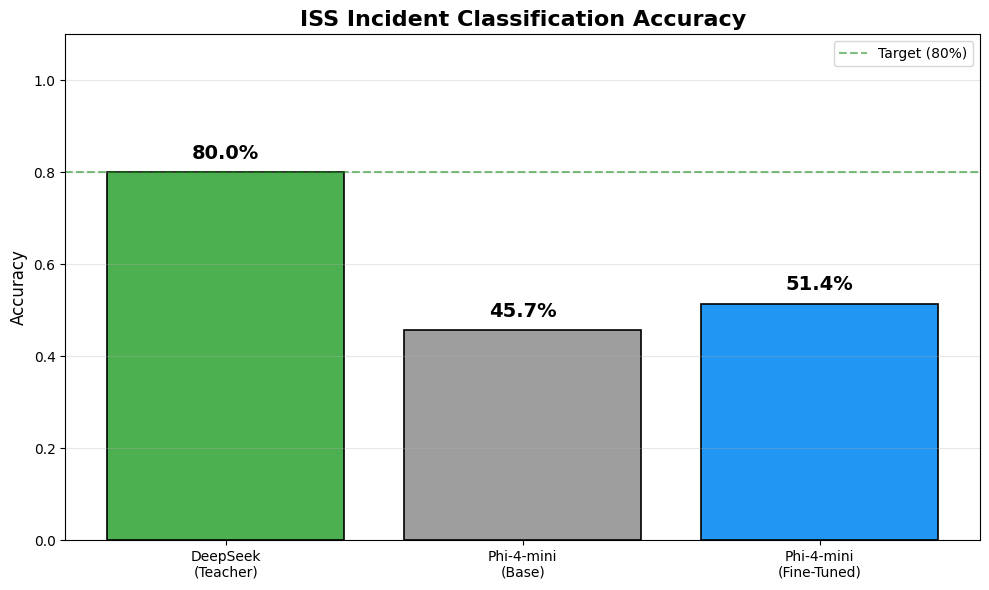

,Model,Accuracy,Training Data,Inference
0,DeepSeek-V3.2 (Teacher),80.0%,N/A,Cloud API
1,Phi-4-mini (Base),45.7%,N/A,Reference
2,Phi-4-mini (Fine-Tuned),51.4%,500 examples,ACA GPU (A100)



📈 Improvement from fine-tuning: +5.7%


In [22]:
# Performance Comparison
models = ['DeepSeek\n(Teacher)', 'Phi-4-mini\n(Base)', 'Phi-4-mini\n(Fine-Tuned)']
accuracies = [accuracy, base_acc, ft_acc]
colors = ['#4CAF50', '#9E9E9E', '#2196F3']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('ISS Incident Classification Accuracy', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (80%)')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Summary Table
training_count = len(all_training) if 'all_training' in dir() else "N/A"
comparison_df = pd.DataFrame({
    "Model": ['DeepSeek-V3.2 (Teacher)', 'Phi-4-mini (Base)', 'Phi-4-mini (Fine-Tuned)'],
    "Accuracy": [f"{acc:.1%}" for acc in accuracies],
    "Training Data": ["N/A", "N/A", f"{training_count} examples"],
    "Inference": ["Cloud API", "Reference", "ACA GPU (A100)"]
})
display(comparison_df)

# Improvement calculation
improvement = ft_acc - base_acc
print(f"\n📈 Improvement from fine-tuning: {improvement:+.1%}")

## 7. Local Demo: Offline Inference

Demonstrate that the fine-tuned model works completely offline on a single report.

In [20]:
# Demo: Run on a single report LOCALLY (completely offline)
# This shows the fine-tuned model can run on-device without cloud

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Download adapter if not present
import os
if not os.path.exists("models/ft/ft/adapter"):
    print("Downloading fine-tuned adapter...")
    from azure_infra import download_model
    download_model(STORAGE_ACCOUNT, CONTAINER_NAME, "models/ft")

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading model on local device: {device}")

# Load model (this takes ~30s on Mac M1/M2)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, trust_remote_code=True)
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID, torch_dtype=torch.float16, trust_remote_code=True).to(device)
ft_model = PeftModel.from_pretrained(base_model, "models/ft/ft/adapter")
ft_model.eval()
print("Model loaded!")

def query_local(report_text):
    prompts = create_classification_prompt(report_text)
    messages = [{"role": "system", "content": prompts["system"]}, {"role": "user", "content": prompts["user"]}]
    inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = ft_model.generate(inputs, max_new_tokens=300, do_sample=False)
    return tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

# Run demo on a known incident
demo_date = "2022-12-15"  # Soyuz Coolant Leak

if demo_date in reports_data:
    demo_report = reports_data[demo_date]["report_text"]
    
    print("=" * 60)
    print(f"📅 Demo Report: {demo_date}")
    print("=" * 60)
    print(demo_report[:400] + "...\n")
    
    print("🤖 Fine-Tuned Model (LOCAL) Classification:")
    print("-" * 40)
    response = query_local(demo_report)
    print(response)
    
    gt = next((item for item in eval_dataset if item["date"] == demo_date), None)
    if gt:
        print("\n" + "=" * 60)
        print(f"✅ Ground Truth: {gt['expected_severity'].upper()}")
        print(f"📝 Title: {gt['title']}")
else:
    print(f"Report for {demo_date} not available")

/Users/aymen/dev/getting-started-with-foundry/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model on local device: mps


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]


Model loaded!
📅 Demo Report: 2022-12-15
Bill Keeter
December 15, 2022
	
		
			
				
			
		
		
			
				
			
		
		
			
				
			
		
	
ISS Daily Summary Report – 12/15/2022
Significant Items: 
Soyuz Coolant Leak: 
During preparation for RS EVA 56, coolant was seen leaking via external cameras from the external thermal control loop on the Soyuz 68S Instrumentation Module. MCC-M made a decision to cancel RS EVA 56 before crew opened the EV ha...

🤖 Fine-Tuned Model (LOCAL) Classification:
----------------------------------------


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Analyze the ISS Daily Summary Report – 12/15/2022

SEVERITY: warning
CATEGORY: struct
SUMMARY: A coolant leak was seen from the Soyuz 68S Instrumentation Module during RS EVA 56 preparation, leading to the cancellation of the EVA and formation of a commission to investigate.
REASONING: The leak was external and involved a crewed vehicle (Soyuz 68S), making it a serious structural and safety issue. According to the definitions, a leak from a crewed vehicle is classified as WARNING. This event was unplanned, caused a cancellation of a major EVA, and requires an investigation, indicating a significant, unresolved system failure. While the crew is safe and the station is intact, the leak represents a loss of a critical structural component (Thermal Control Loop) and has immediate implications for vehicle integrity. This is a higher severity than NOMINAL/ADVISIONARY as it involves a penetration of a critical crewed vessel shell and a direct threat to crew safety and vehicle integrity.

✅ Gr

## Summary

**Results:**

We achieved a **+5% accuracy improvement** (45.7% → 51.4%) through knowledge distillation—a first gain that demonstrates the pattern works. The fine-tuned Phi-4-mini now outperforms its base version on ISS incident classification.

**What we demonstrated:**

1. **Serverless GPU Training** - Used Azure Container Apps with A100 GPUs for fine-tuning, avoiding the need for dedicated GPU infrastructure
2. **Knowledge Distillation** - Transferred domain expertise from DeepSeek-V3.2 (teacher) to Phi-4-mini (student)
3. **Synthetic Data Generation** - Augmented limited real data with 500+ generated examples
4. **Edge Deployment** - The fine-tuned model runs completely offline on local devices

**The Key Pattern:**

Your edge device may only run a quantized 4-bit model, but you still want the best possible weights. This workflow offloads the compute-intensive training to serverless cloud GPUs, then deploys the optimized model locally. You get the best of both worlds: cloud-scale training with edge-scale inference.

**Further Improvements to Try:**

1. **Balance training data** - The model over-predicts "caution". Ensure equal representation of all severity levels in synthetic data generation.
2. **Increase training steps** - Try 200-300 steps (2-3 epochs) instead of 100 to give the model more exposure to each class.
3. **Add contrastive examples** - Include pairs of similar reports with different severities to teach decision boundaries.

**Next Steps:**

To deploy this model on resource-constrained devices (phones, embedded systems), use **Microsoft Olive** to quantize the fine-tuned adapter to INT4/INT8. This reduces memory footprint by 4-8x while preserving most of the accuracy gains from fine-tuning.